# Import Libraries

In [1]:
# Enable import from different directory
import sys
sys.path.insert(0, 'C:/Users/melis/Desktop/FYP Stuff/comma2k19_dataset/notebooks/lib/')

import os
import numpy as np
import cv2
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Set Up Directory of Videos (Dataset)

In [2]:
BASE_PATH = 'C:/Users/melis/Desktop/FYP Stuff/comma2k19_dataset/CleanDataset1/'
dirs = os.listdir(BASE_PATH)
print(len(dirs)) # number of files in the directory

1


# Load Global Position Metadata of the Video

In [3]:
import orientation as orient

frame_times_list = []
frame_position_list = []
frame_orientation_list = []

for i in dirs:
    frame_times = np.load(BASE_PATH + i + '/global_pose/frame_times')
    frame_times = frame_times - frame_times[0]
    # global positions in ECEF of camera(m)
    frame_positions = np.load(BASE_PATH + i + '/global_pose/frame_positions')
    # global orientations as quaternion
    frame_orientations = np.load(BASE_PATH + i + '/global_pose/frame_orientations')
    
    frame_times_list.append(frame_times)
    frame_position_list.append(frame_positions)
    frame_orientation_list.append(frame_orientations)

# Preparing Plots for Data Annotation on Horizontal Curve

* There is only 1 video for demo purposes. 
* There are 1200 frames per video, 20fps. 
* Each video is 60s.

In this section, I will be using the metadata on global position:

* Frame orientation - Global orientations as quaternion
* Frame positions - Global positions in ECEF of camera (meters)

Steps:
1. Convert frame orientation in quaternions to rotation matrix
2. Use rotation matrix to rotate frame position in global frame to local camera frame (defined as forward, right, down)
3. For each local camera frame position, store the coordinate of forward and right until 100m forward
4. Continue with next local camera frame position and repeat step 3 until the last frame with 100m forward

In [4]:
y_training = []
down_fit_data = []
breakpoints = []
y_functions = []

for i in range(len(dirs)):
    
    cnt = 0
    
    while True:
        # Perform transformation on ECEF frame to local frame
        # ECEF units are in meters
        ecef_from_local = orient.rot_from_quat(frame_orientation_list[i][cnt])
        local_from_ecef = ecef_from_local.T
        frame_positions_local_all = np.einsum('ij,kj->ki', local_from_ecef, frame_position_list[i][cnt:] - frame_position_list[i][cnt])
        
        forward = frame_positions_local_all[:,0]
        right = frame_positions_local_all[:,1]
        down = frame_positions_local_all[:,2]
        
        # Look for the 100th point index (100m)
        index = next((i for i,j in enumerate(forward) if j >= 100), None)
        
        if index == None: # end of forward
            breakpoints.append(cnt)
            break

        # Polyfit a 11th degree order polynomial to the right coordinate
        coeff = np.polyfit(forward[0:index],right[0:index],11)
        ffit = np.poly1d(coeff)
        
        x_new = np.linspace(0,99,100)
        y_new = ffit(x_new)

        y_training.append(y_new)
        
        cnt += 1 # next frame
        
y_training = np.array(y_training)
theta = np.radians(-2)
transformed_y = np.ones((y_training.shape))
for ee in range(y_training.shape[0]):
    for i in range(len(y_training[ee])):
        transformed_y[ee][i] = (i)*np.sin(theta)+y_training[ee][i]*np.cos(theta)

print(y_training.shape) # (number of plots, position at "right" at each meter until 100)

(1120, 100)


# Convert Video Into Frames

The frames will be tally with the number of plots prepared

In [5]:
TOTAL_FRAMES = 1200
yuv_imgs = []

for i in range(len(dirs)):
    vid = cv2.VideoCapture(BASE_PATH + dirs[i] + '/video.hevc')
    for frame_number in tqdm(range(TOTAL_FRAMES)):
        ret, frame = vid.read()      
        frame = cv2.resize(frame,(1164, 874)) # 1164x874 original
#       crop_img = frame[350:670, 100:1100] # crop image
#       frame = cv2.resize(crop_img,(256, 128)) # resize to 256x128
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if frame_number == breakpoints[i]: # to make sure it is the same as the y_training frames
            break
        yuv_imgs.append(frame)

 93%|████████████████████████████████████████████████████████████████████████▊     | 1120/1200 [00:20<00:01, 54.56it/s]


# Plotting Road Path

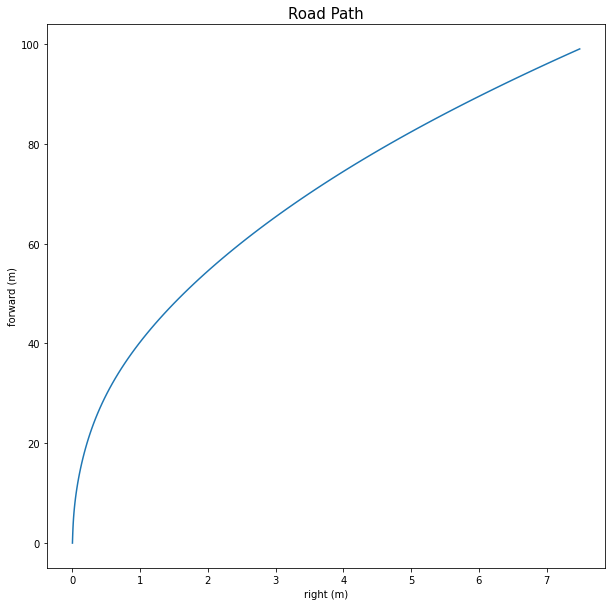

In [6]:
img_frame = 679

plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(transformed_y[img_frame], x_new)
xlabel("right (m)")
ylabel("forward (m)")

title('Road Path', fontsize=15);

# Calculate Angle using Trigonometry

* Negative angle = left horizontal curve
* Positive angle =  right horizontal curve

Classify image into:
* more than or equal to 80e-03
* 50e-03 to 79e-03
* 30e-03 to 49e-03
* <30e-03 (consider as straight road)

There will be a total of 7 categories:
* 3 left
* 3 right
* straight

In [7]:
right = transformed_y[img_frame][99]
adjacent = 100
angle = np.arctan(right/adjacent)
print("Angle:", "{:.1e}".format(angle))

Angle: 7.5e-02


# Display Single Frame

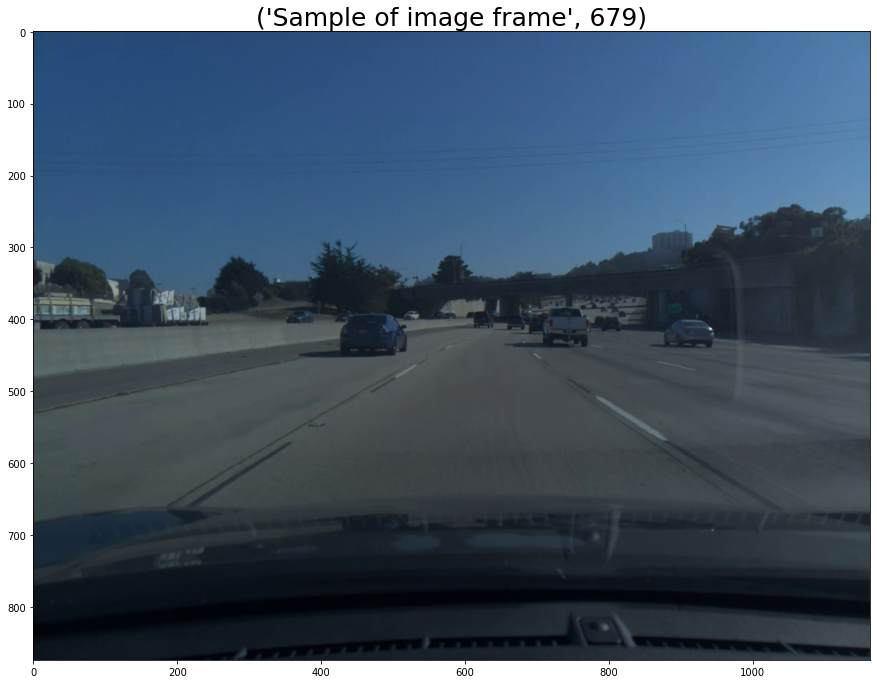

In [8]:
figsize(15,15);
imshow(yuv_imgs[img_frame]);
title(('Sample of image frame', img_frame), fontsize=25);

# Display Multiple Frames

In [ ]:
def show_images(images, rows = 5, cols = 4, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.axis('off')
            

show_images(yuv_imgs[:6], cols=2, rows=3)

# Lane Detection for Ego-Car Position Classification

## Mark Region for Bird's Eye View Transformation

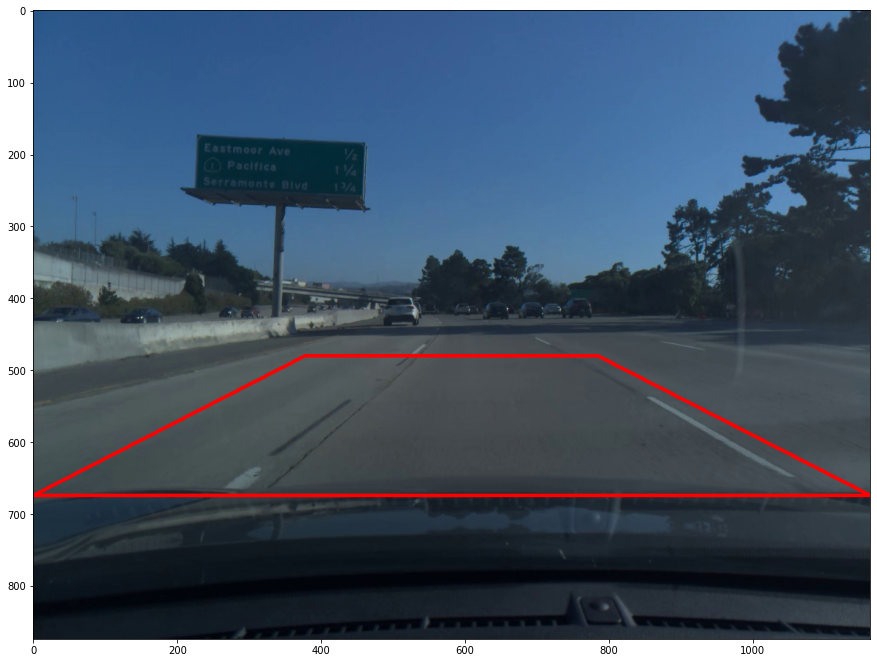

In [9]:
frme = 55

duplicate = yuv_imgs[frme].copy()

# Drawing the line for visualization
image_transform = yuv_imgs[frme]

trap_height_percentage = 0.55
trap_bottom_width_offset = 0
trap_top_width_offset = 0.325

imshape = duplicate.shape
height = imshape[0]
width = imshape[1]

top_left = [int(width * trap_top_width_offset), int(height * trap_height_percentage)]
top_right = [int(width * (1-trap_top_width_offset)), int(height * trap_height_percentage)]
btm_left = [int(width * trap_bottom_width_offset), height-200]
btm_right = [int(width * (1-trap_bottom_width_offset)), height-200]
line_width = 3
color = [255,0,0]

cv2.line(image_transform, tuple(top_left), tuple(top_right), color, line_width)
cv2.line(image_transform, tuple(btm_left), tuple(top_left), color, line_width)
cv2.line(image_transform, tuple(btm_left), tuple(btm_right), color, line_width)
cv2.line(image_transform, tuple(top_right), tuple(btm_right), color, line_width)

plt.imshow(image_transform)

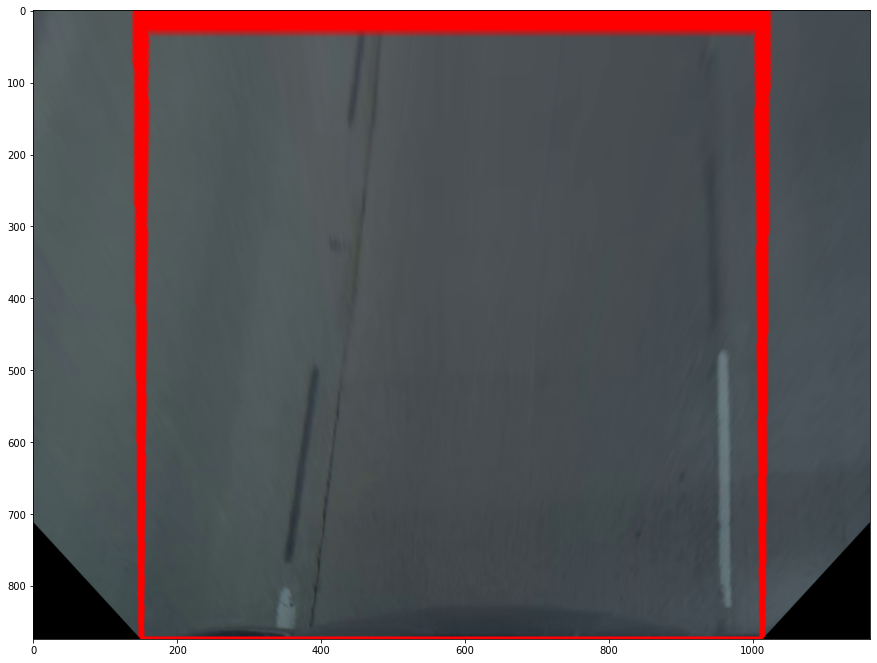

In [10]:
img_size = (image_transform.shape[1],image_transform.shape[0])
offset = 150

src = np.float32([top_left,top_right,btm_right,btm_left])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0],
                  [img_size[0] - offset, img_size[1]],[offset,img_size[1]]])

M = cv2.getPerspectiveTransform(src,dst)
inv_M = cv2.cv2.getPerspectiveTransform(dst,src)

imshow(cv2.warpPerspective(image_transform, M, img_size))

# Detect Lane Line

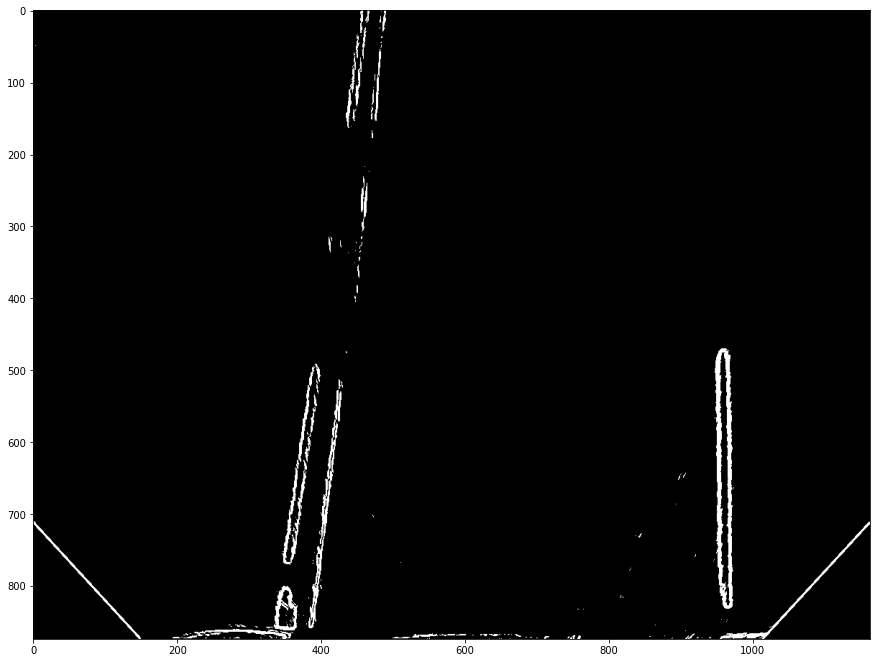

In [11]:
# Building the pipeline

def pre_pipeline(img):
    
    def img_thres(img, tmin, tmax):
        """
        To apply a threshold to the img and returning a binary image of 
        either 0 or 255
        """
        binary_img = np.zeros_like(img)
        binary_img[(img >= tmin) & (img <= tmax)] = 1
        return binary_img

    def edge_detector(img, sobel_kernel=9, tmin=0, tmax=255):
   
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255
    
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        return img_thres(gradmag, tmin, tmax)
        
    # Converting the color space from RGB to HLS
    # Selecting only the S channel as this gives the best contrast
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,1]
    
    # Applying sobel edge detector
    edge = edge_detector(hls, 3, 15, 255)
    
    return edge
    
binary = pre_pipeline(cv2.warpPerspective(duplicate, M, img_size))
plt.imshow(binary, cmap='gray')

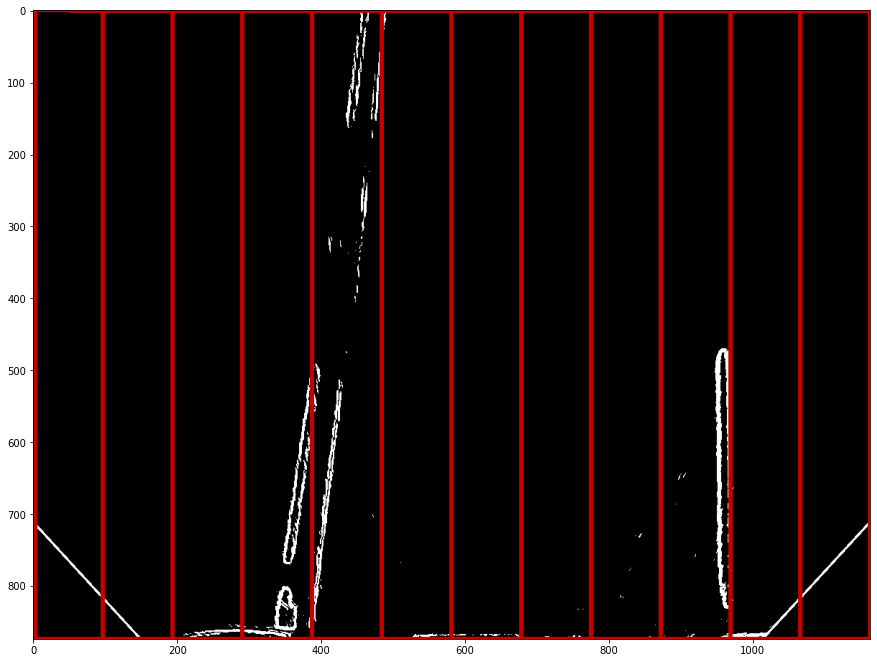

In [12]:
# Drawing the line for visualization

duplicate2 = binary.copy()

def convert_to_rgb(img):
    
    rgb_img = np.zeros_like(img)
    rgb_img[(img == 1)] = 255
    return rgb_img

def display_created_windows(img):

    imshape = img.shape
    height = imshape[0] # 874
    width = imshape[1] # 1164
    # Factors of 1164 :  1, 2, 3, 4, 6, 12, (97), 194, 291, 388, 582, 1164
    
    for i in range(0, 1164, 97):        
        top_left = (i, 1)
        top_right = (i+96, 1)
        btm_left = (i, height-1)
        btm_right = (i+96, height-1)
        
        if i == 0:
            top_left = (3, 0)
            btm_left = (3, height-1) 
        
        line_width = 3
        
        
        cv2.line(img, top_left, top_right, 200,line_width)
        cv2.line(img, btm_left, top_left, 200,line_width)
        cv2.line(img, btm_left, btm_right, 200, line_width)
        cv2.line(img, top_right, btm_right, 200, line_width)
        
        
    return img

img = convert_to_rgb(duplicate2)
img = np.dstack([img,img,img])
img = display_created_windows(img)
plt.imshow(img)

# Classify Ego-Car Position

Classify into:
* left
* middle
* right

In [13]:
def find_white(img):
    imshape = img.shape
    height = imshape[0] # 874
    width = imshape[1] # 1164
    windows = []
    for i in range(0, 1164, 97):
        windows.append(sum(img[:, i:i+96]))
    
    
    print(windows)
    index = np.linspace(0,11,12)
    windows, index = zip(*sorted(zip(windows, index)))
    
    dist = np.absolute(index[-1] - index[-2])
    
    if dist==6 or dist==5 or dist==7:
        val = index[-1] + index[-2]
    else:
        while True:
            for i in range(len(index)-1,len(index)-4,-1):
                for j in range(i-1,len(index)-5,-1):
                    dist = np.absolute(index[i] - index[j])
                    val = index[i] + index[j]
                    if dist==6 or dist==5 or dist==7:
                        break
                if dist==6 or dist==5 or dist==7:
                    break
            if dist==6 or dist==5 or dist==7:
                break
            else:
                print("fail")
                break
    # set threshold        
    if val>=13:
        print("Slightly out of lane - Left")
    elif val>=10:
        print("Middle of lane")
    else:
        print("Slightly out of lane - Right")
    
    
    
find_white(duplicate2)

[458, 246, 371, 3002, 3849, 257, 106, 72, 25, 3638, 1077, 458]
Slightly out of lane - Left
